# Import packages and modules

In [2]:
# This magic command plots figures directly in the notebook
%matplotlib inline
# This sets a higher resolution for figures
%config InlineBackend.figure_format = 'retina'

import os
import scipy.io
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, hilbert


from neurodsp.utils import create_times
from neurodsp.plts import plot_time_series


# Filtering and circle correlation functions

In [3]:
def butter_bandpass(lowcut, highcut, fs, order=4):
    #lowcut is the lower bound of the frequency that we want to isolate
    #hicut is the upper bound of the frequency that we want to isolate
    #fs is the sampling rate of our data
    nyq = 0.5 * fs #nyquist frequency - see http://www.dspguide.com/ if you want more info
    low = float(lowcut) / nyq
    high = float(highcut) / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(mydata, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, mydata)
    return y

def circCorr(ang,line):
    n = len(ang)
    rxs = sp.stats.pearsonr(line,np.sin(ang))
    rxs = rxs[0]
    rxc = sp.stats.pearsonr(line,np.cos(ang))
    rxc = rxc[0]
    rcs = sp.stats.pearsonr(np.sin(ang),np.cos(ang))
    rcs = rcs[0]
    rho = np.sqrt((rxc**2 + rxs**2 - 2*rxc*rxs*rcs)/(1-rcs**2)) #r
    r_2 = rho**2 #r squared
    pval = 1- sp.stats.chi2.cdf(n*(rho**2),1)
    standard_error = np.sqrt((1-r_2)/(n-2))

    return rho, pval, r_2,standard_error

# Metadata

In [4]:
# dataset
subjects=['al','ca','cc','de','fp','gc','gf','gw',
          'h0','hh','jc','jm','jp','mv','rh','rr',
          'ug','wc','wm','zt']
os.chdir(r'C:\Users\jaapv\Desktop\master\VoytekLab')
dataset = 'fixation_pwrlaw'
fs = 1000


# Selecting frequency bands 
phase_providing_band = [4,8]; #4-8 Hz band
amplitude_providing_band = [80, 125]; #80-125 Hz band

# time plot in seconds
plt_time = [60, 62]

# Load subject data

In [5]:
# sub data
subj = 16
ch = 17

# get the filename
sub_label = subjects[subj] + '_base'
filename = os.path.join(os.getcwd(), dataset, 'data', sub_label)

# load data
dataStruct = sp.io.loadmat(filename)
data = dataStruct['data']
locs = dataStruct['locs']

sig = data[:,ch]

# Plot data with plt.plot and neuroDSP

C:\Users\jaapv\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


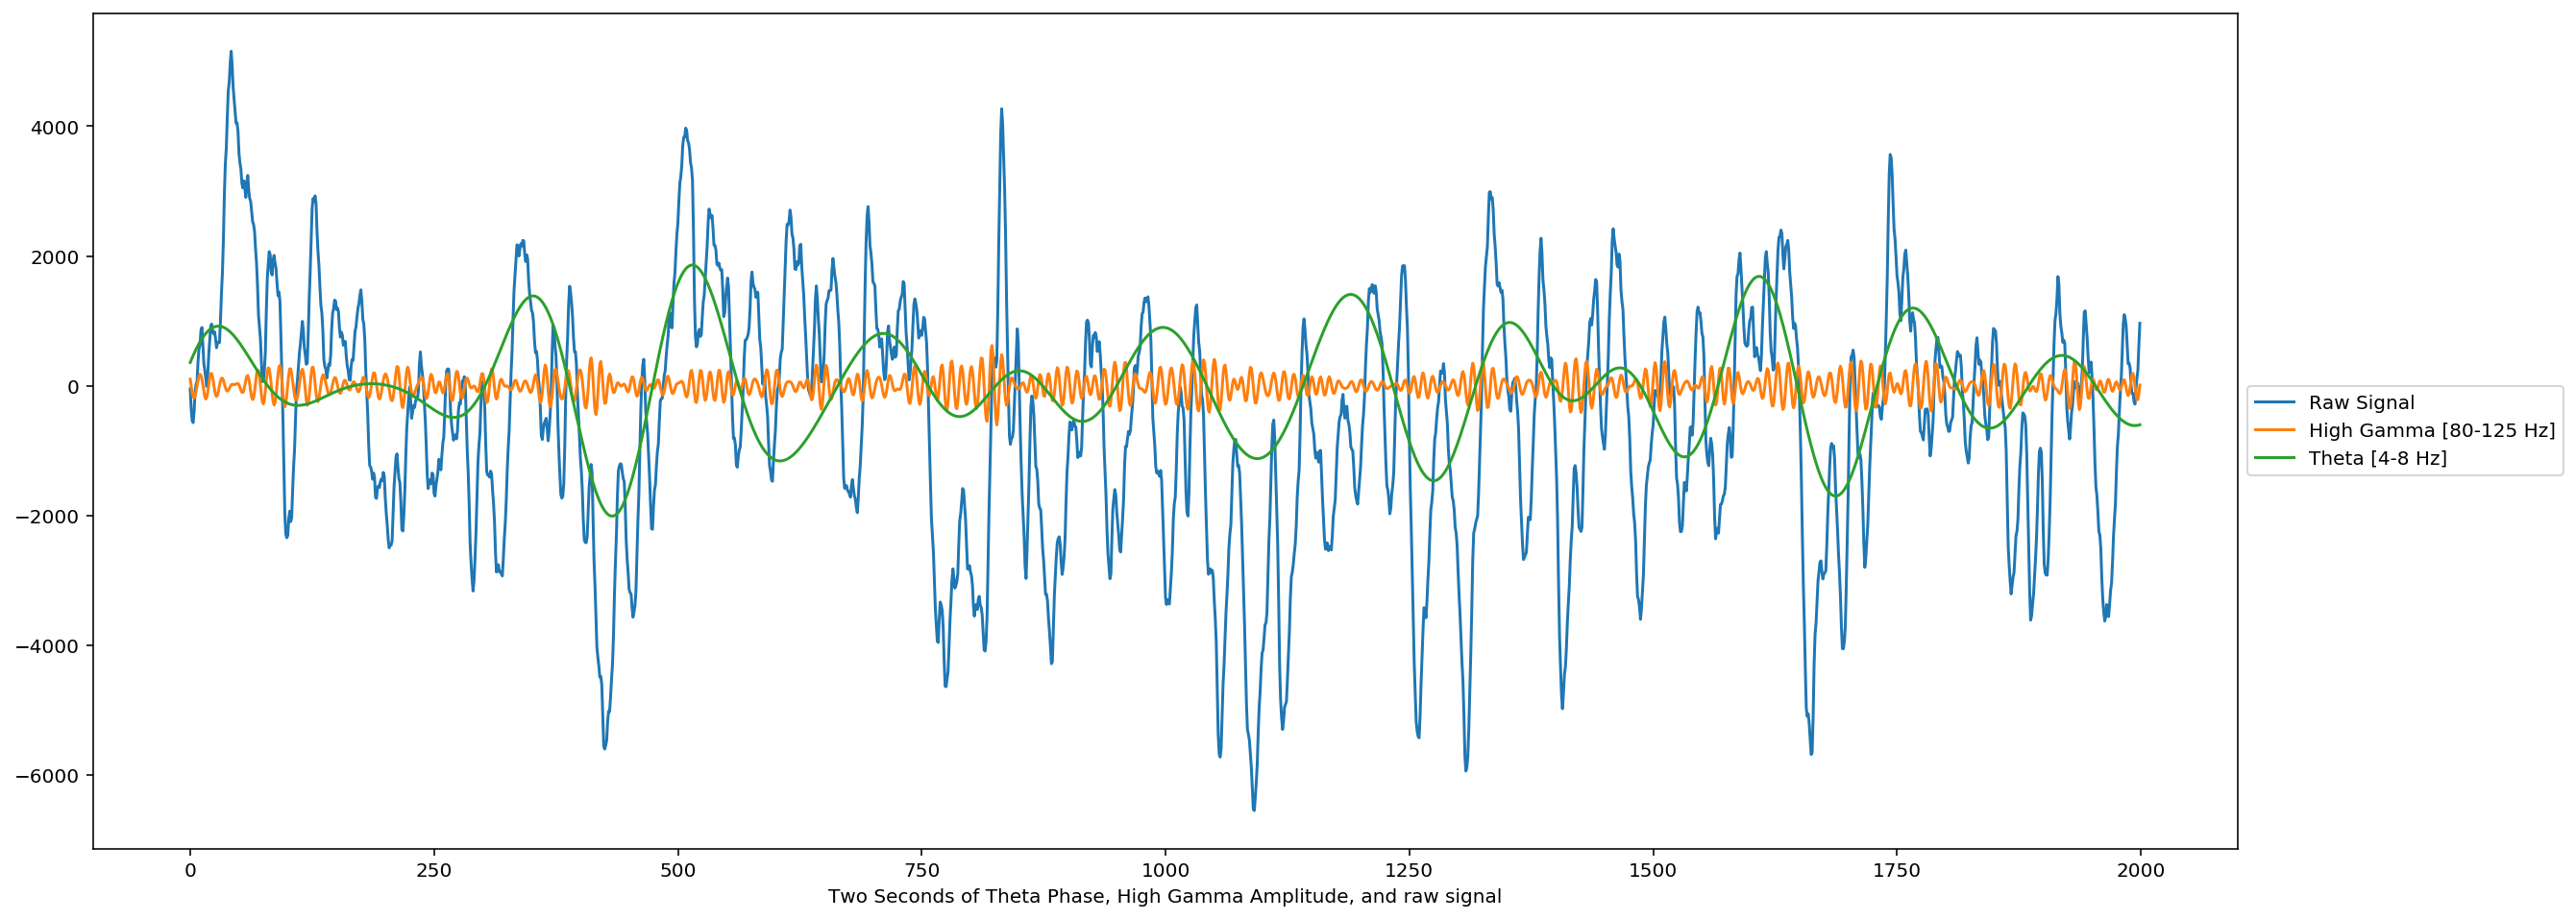

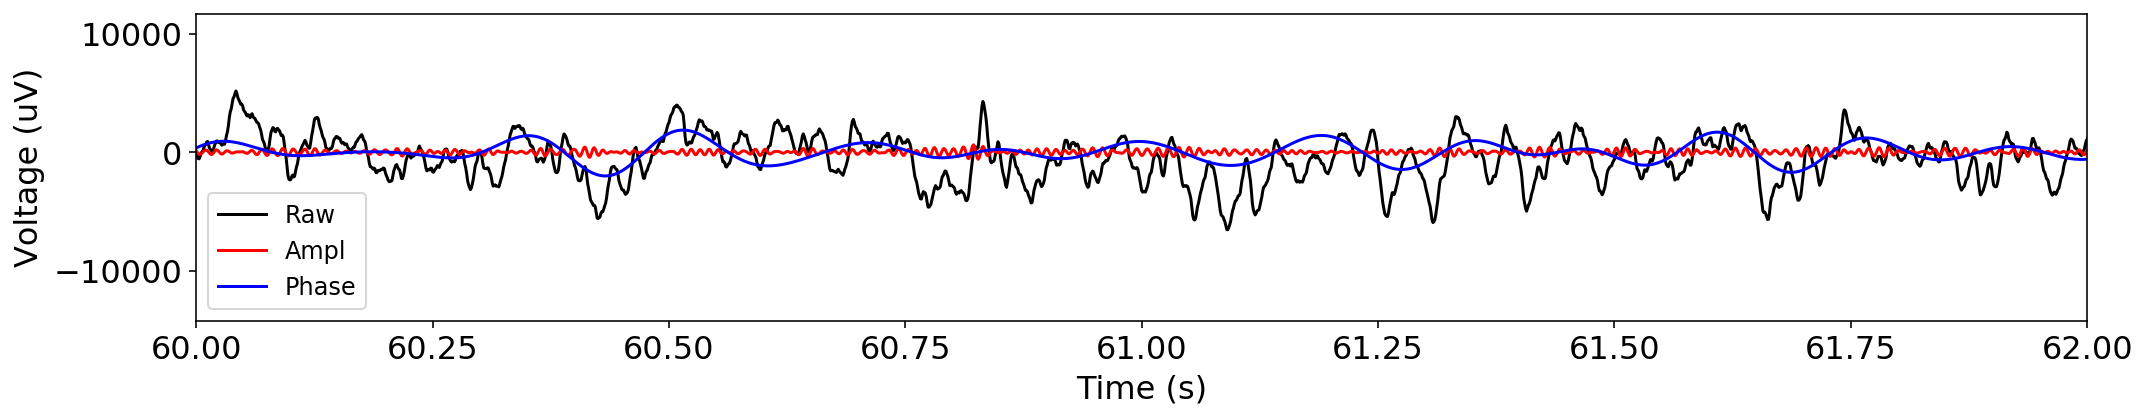

In [6]:
#calculating phase of theta
phase_data = butter_bandpass_filter(data[:,ch], phase_providing_band[0], phase_providing_band[1], round(float(fs)));
phase_data_hilbert = hilbert(phase_data);
phase_data_angle = np.angle(phase_data_hilbert);

#calculating amplitude envelope of high gamma
amp_data = butter_bandpass_filter(data[:,ch], amplitude_providing_band[0], amplitude_providing_band[1], round(float(fs)));
amp_data_hilbert = hilbert(amp_data);
amp_data_abs = abs(amp_data_hilbert);

PAC_values = circCorr(phase_data_angle, amp_data_abs)


# one way to visualize it using plt.plot
plt.figure(figsize = (20,8));
plt.plot((data[plt_time[0]*fs:plt_time[1]*fs,ch]),label= 'Raw Signal')
plt.plot((amp_data_hilbert[plt_time[0]*fs:plt_time[1]*fs]),label= 'High Gamma [80-125 Hz]')
plt.plot((phase_data_hilbert[plt_time[0]*fs:plt_time[1]*fs]),label= 'Theta [4-8 Hz]')

plt.xlabel('Two Seconds of Theta Phase, High Gamma Amplitude, and raw signal')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# other way using neurodsp.plts
times = create_times(len(sig)/fs, fs)
times = times[0:len(times)-1]
plot_time_series(times, [sig, amp_data_hilbert, phase_data_hilbert], ['Raw', 'Ampl', 'Phase'], xlim=plt_time)